##  Piza Nava Vladimir - 111-494


## Laboratorio 5

## Link al repositorio: https://github.com/vladi-13/Laboratorio4y5/blob/main/Laboratorio5.ipynb

## Link al dataset: https://www.kaggle.com/datasets/vladi13/dataset-flores-piza-nava-vladimir

Importación de librerías:

Se importan varias librerías estándar y específicas para trabajar con imágenes y redes neuronales.

Configuración del dispositivo:

Usa DirectML para habilitar el uso de la GPU AMD si está disponible.


In [49]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from tqdm import tqdm
from PIL import Image
import torch_directml
import random

# Configuración del dispositivo para GPU AMD con DirectML
device = torch_directml.device()
print(f"Usando dispositivo: {device}")

Usando dispositivo: privateuseone:0


Definición de la ruta y las clases:

El código está configurado para trabajar con un conjunto de datos de imágenes, donde las clases son diferentes tipos de flores.

Carga aleatoria de imágenes:

Selecciona un número específico de imágenes aleatorias por clase, redimensionándolas a un tamaño uniforme (256x256) y convirtiéndolas en matrices.

Almacenaje de imágenes y etiquetas:

Se almacenan las imágenes y sus respectivas etiquetas (clase) en listas, que luego se convierten en arreglos de NumPy.

In [50]:
root_dir = r'Dataset-Flores'  # Reemplaza con la ruta correcta
classes = ['Astromelia', 'Cartucho', 'Lirio', 'Obispo', 'SanJuan']
num_images_per_class = 2000  # Seleccionamos 2000 imágenes por clase

def load_random_images(folder, label, num_samples):
    all_files = [f for f in os.listdir(folder) if os.path.isfile(os.path.join(folder, f))]
    selected_files = random.sample(all_files, min(num_samples, len(all_files)))
    images = []
    labels = []
    for filename in tqdm(selected_files, desc=f'Cargando {os.path.basename(folder)}'):
        img_path = os.path.join(folder, filename)
        try:
            img = Image.open(img_path).convert('RGB')
            img = img.resize((256, 256))  # Redimensionar a 256x256
            images.append(np.array(img))
            labels.append(label)
        except Exception as e:
            print(f"Error con {filename}: {e}")
    return images, labels

images = []
labels = []

for idx, class_name in enumerate(classes):
    folder_path = os.path.join(root_dir, class_name)
    class_images, class_labels = load_random_images(folder_path, idx, num_images_per_class)
    images.extend(class_images)
    labels.extend(class_labels)

images = np.array(images)
labels = np.array(labels)

Cargando SanJuan: 100%|██████████| 2000/2000 [00:12<00:00, 155.13it/s]


Visualización de imágenes aleatorias: Muestra una cuadrícula de imágenes aleatorias del conjunto de datos con sus etiquetas correspondientes (las clases de flores).

Conteo de clases: Muestra la distribución de clases (cuántas imágenes hay de cada clase en el conjunto de datos).

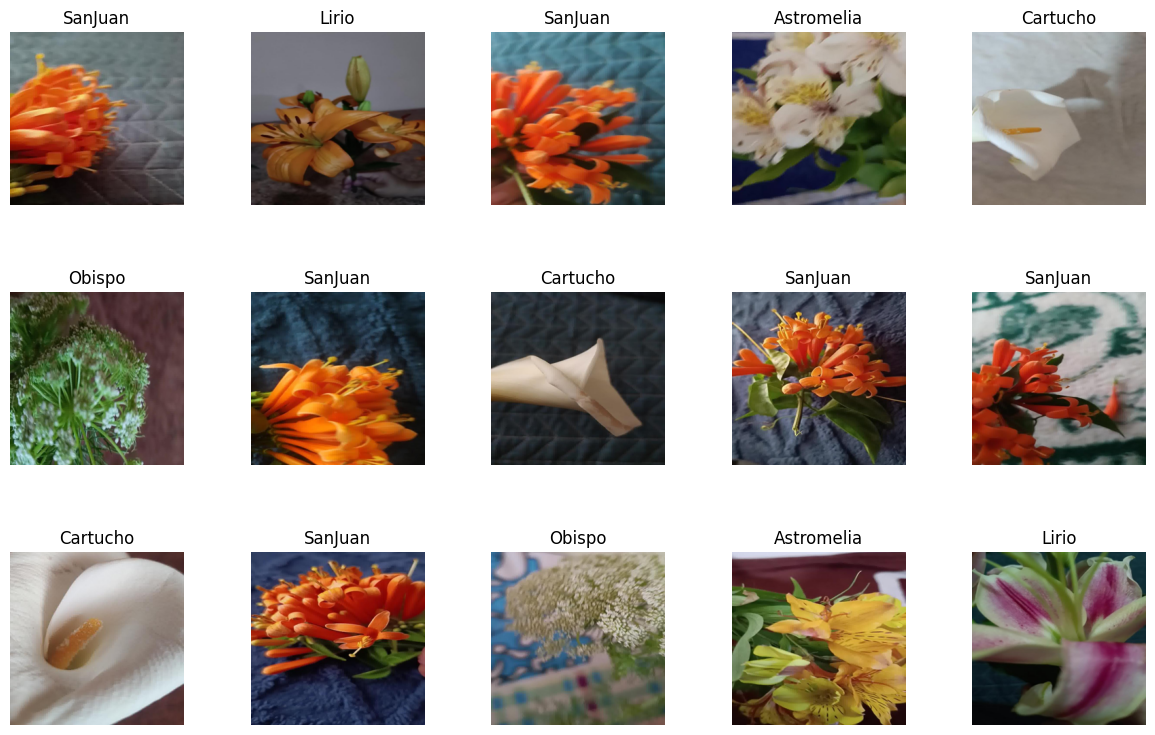

Distribución de clases: {np.int64(0): np.int64(2000), np.int64(1): np.int64(2000), np.int64(2): np.int64(2000), np.int64(3): np.int64(2000), np.int64(4): np.int64(2000)}


In [ ]:
r, c = 3, 5 # Número de filas y columnas para la visualización
plt.figure(figsize=(c*3, r*3))
for row in range(r):
    for col in range(c):
        index = c * row + col
        plt.subplot(r, c, index + 1)
        ix = np.random.randint(0, len(images))
        img, label = images[ix], labels[ix]
        plt.imshow(img)
        plt.axis('off')
        plt.title(classes[label])
plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()

# Conteo de clases
unique_train, counts_train = np.unique(labels, return_counts=True)
print("Distribución de clases:", dict(zip(unique_train, counts_train)))

Este fragmento de código prepara las imágenes del conjunto de datos para ser utilizadas en un modelo de aprendizaje profundo (como una red neuronal convolucional) al aplicar una serie de transformaciones a las imágenes y luego cargarlas en un DataLoader de PyTorch.

In [61]:
transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Redimensionar imágenes a 256x256
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])  # Normalizar imágenes
])

dataset = ImageFolder(root=root_dir, transform=transform)
dataloader = DataLoader(dataset, batch_size=128, shuffle=True)

Este fragmento de código define dos clases principales en una Red Generativa Antagónica (GAN, por sus siglas en inglés), que son el Generador y el Discriminador. Estos modelos son la base para la creación de nuevas imágenes realistas, y están construidos con capas convolucionales y transpuestas (en el caso del generador).

In [ ]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.input_size = 100
        self.inp = nn.Sequential(
            nn.Linear(self.input_size, 512 * 4 * 4),
            nn.BatchNorm1d(512 * 4 * 4),
            nn.ReLU(True)
        )
        self.main = nn.Sequential( # Convulociones transpuestas
            nn.ConvTranspose2d(512, 256, 4, 2, 1),  # 8x8
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.ConvTranspose2d(256, 128, 4, 2, 1),  # 16x16
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, 4, 2, 1),   # 32x32
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 32, 4, 2, 1),    # 64x64
            nn.BatchNorm2d(32),
            nn.ReLU(True),
            nn.ConvTranspose2d(32, 16, 4, 2, 1),    # 128x128
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 3, 4, 2, 1),     # 256x256
            nn.Tanh() # Salida entre -1 y 1
        )

    def forward(self, x):
        x = self.inp(x)
        x = x.view(-1, 512, 4, 4)
        return self.main(x)

class Discriminator(nn.Module):
    def __init__(self, input_channels=3):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(input_channels, 16, 4, 2, 1),   # 3x256x256 -> 16x128x128
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(16, 32, 4, 2, 1),              # 16x128x128 -> 32x64x64
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(32, 64, 4, 2, 1),             # 32x64x64 -> 64x32x32
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, 4, 2, 1),            # 64x32x32 -> 128x16x16
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, 4, 2, 1),           # 128x16x16 -> 256x8x8
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 512, 4, 2, 1),           # 256x8x8 -> 512x4x4
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True)
        )
        
        # Usamos pooling adaptativo para garantizar dimensiones fijas
        self.adaptive_pool = nn.AdaptiveAvgPool2d((1, 1))
        # Ahora siempre será 512 características
        self.out = nn.Linear(512, 1)
        
    def forward(self, x):
        x = self.main(x)
        x = self.adaptive_pool(x)  # Reduce a 512x1x1
        x = x.view(x.size(0), -1)  # Aplana a 512 características
        x = torch.sigmoid(self.out(x))
        return x

# Inicializar modelos
generator = Generator().to(device)
discriminator = Discriminator().to(device)

Este código implementa un ciclo de entrenamiento para una Red Generativa Antagónica (GAN) utilizando el modelo de un Generador y un Discriminador. Además, incluye el uso de Early Stopping (detención temprana) para evitar sobreajuste, y guarda los checkpoints del modelo, las pérdidas y las imágenes generadas durante el proceso de entrenamiento.

In [ ]:
import time
from datetime import datetime

class EarlyStopping:
    def __init__(self, patience=10, min_delta=0.0001):
        self.patience = patience
        self.min_delta = min_delta
        self.best_loss = None
        self.counter = 0
        self.early_stop = False

    def __call__(self, loss):
        if self.best_loss is None or loss < self.best_loss - self.min_delta:
            self.best_loss = loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

def fit(generator, discriminator, dataloader, crit, num_epochs, patience=10):
    optimizer_g = torch.optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
    optimizer_d = torch.optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

    history = {'loss_g': [], 'loss_d': []}
    checkpoint_dir = 'CheckpointsDCGANs'
    os.makedirs(checkpoint_dir, exist_ok=True)
    early_stopping = EarlyStopping(patience=patience)

    for epoch in range(num_epochs):
        epoch_start_time = time.time()
        loop = tqdm(dataloader, desc=f'Epoch [{epoch+1}/{num_epochs}]')

        epoch_loss_g = 0
        epoch_loss_d = 0
        batches = 0

        for imgs, _ in loop:
            batch_size = imgs.size(0)
            imgs = imgs.to(device)
            batches += 1

            # Discriminador
            optimizer_d.zero_grad()
            real_labels = torch.ones(batch_size, 1, device=device)
            fake_labels = torch.zeros(batch_size, 1, device=device)

            outputs = discriminator(imgs)
            d_loss_real = crit(outputs, real_labels)
            d_loss_real.backward()

            # Generar imágenes falsas 
            noise = torch.randn(batch_size, generator.input_size, device=device)
            fake_imgs = generator(noise)
            outputs = discriminator(fake_imgs.detach())
            d_loss_fake = crit(outputs, fake_labels)
            d_loss_fake.backward()
            optimizer_d.step()

            # Generador
            optimizer_g.zero_grad()
            outputs = discriminator(fake_imgs)
            g_loss = crit(outputs, real_labels)
            g_loss.backward()
            optimizer_g.step()

            d_loss = d_loss_real.item() + d_loss_fake.item()
            epoch_loss_g += g_loss.item()
            epoch_loss_d += d_loss

            loop.set_postfix(G_loss=g_loss.item(), D_loss=d_loss)

        avg_loss_g = epoch_loss_g / batches
        avg_loss_d = epoch_loss_d / batches
        history['loss_g'].append(avg_loss_g)
        history['loss_d'].append(avg_loss_d)
        
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss G: {avg_loss_g:.4f}, Loss D: {avg_loss_d:.4f}")

        early_stopping(avg_loss_g)
        if early_stopping.early_stop:
            print(f"Early stopping en la época {epoch+1}")
            break

        if (epoch + 1) % 5 == 0:
            timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
            torch.save({
                'epoch': epoch + 1,
                'generator_state_dict': generator.state_dict(),
                'discriminator_state_dict': discriminator.state_dict(),
                'optimizer_g_state_dict': optimizer_g.state_dict(),
                'optimizer_d_state_dict': optimizer_d.state_dict(),
                'loss_g': history['loss_g'],
                'loss_d': history['loss_d'],
            }, os.path.join(checkpoint_dir, f'checkpoint_epoch_{epoch+1}_{timestamp}.pth'))
            
            # También guardamos imágenes generadas para ver progreso
            with torch.no_grad():
                test_noise = torch.randn(16, generator.input_size, device=device)
                fake_imgs = generator(test_noise)
                fake_imgs = fake_imgs.detach().cpu()
                
                # Guardar las imágenes generadas
                plt.figure(figsize=(10, 10))
                for i in range(16):
                    plt.subplot(4, 4, i+1)
                    img = fake_imgs[i].permute(1, 2, 0).numpy()
                    img = (img * 0.5 + 0.5).clip(0, 1)  # Desnormalizar
                    plt.imshow(img)
                    plt.axis('off')
                plt.tight_layout()
                plt.savefig(os.path.join(checkpoint_dir, f'generated_epoch_{epoch+1}.png'))
                plt.close()

        print(f"Tiempo por epoch: {time.time() - epoch_start_time:.2f} s")

    # Guardar los modelos finales
    torch.save(generator.state_dict(), 'generator_final.pth')
    torch.save(discriminator.state_dict(), 'discriminator_final.pth')
    return history

Este código está diseñado para entrenar y evaluar un modelo de Generative Adversarial Network (GAN). En particular, genera y visualiza la evolución de las pérdidas durante el entrenamiento y, al finalizar, produce y visualiza las imágenes generadas por el generador después del entrenamiento. 

Epoch [1/30]: 100%|██████████| 391/391 [11:34<00:00,  1.78s/it, D_loss=0.096, G_loss=3.32] 


Epoch [1/30], Loss G: 2.2127, Loss D: 0.4295
Tiempo por epoch: 694.30 s


Epoch [2/30]: 100%|██████████| 391/391 [11:22<00:00,  1.75s/it, D_loss=0.422, G_loss=2.3]  


Epoch [2/30], Loss G: 3.6930, Loss D: 0.1603
Tiempo por epoch: 682.84 s


Epoch [3/30]: 100%|██████████| 391/391 [11:18<00:00,  1.74s/it, D_loss=0.549, G_loss=2.91] 


Epoch [3/30], Loss G: 3.4447, Loss D: 0.1910
Tiempo por epoch: 678.91 s


Epoch [4/30]: 100%|██████████| 391/391 [11:20<00:00,  1.74s/it, D_loss=0.903, G_loss=3.78] 


Epoch [4/30], Loss G: 2.1215, Loss D: 0.7801
Tiempo por epoch: 680.58 s


Epoch [5/30]: 100%|██████████| 391/391 [11:06<00:00,  1.70s/it, D_loss=1.32, G_loss=2.76]  


Epoch [5/30], Loss G: 2.2308, Loss D: 0.7384
Tiempo por epoch: 667.89 s


Epoch [6/30]: 100%|██████████| 391/391 [11:16<00:00,  1.73s/it, D_loss=0.639, G_loss=2.03] 


Epoch [6/30], Loss G: 2.0922, Loss D: 0.7904
Tiempo por epoch: 676.18 s


Epoch [7/30]: 100%|██████████| 391/391 [11:19<00:00,  1.74s/it, D_loss=1.38, G_loss=0.728] 


Epoch [7/30], Loss G: 2.0431, Loss D: 0.7761
Tiempo por epoch: 679.82 s


Epoch [8/30]: 100%|██████████| 391/391 [11:17<00:00,  1.73s/it, D_loss=0.672, G_loss=2.2]  


Epoch [8/30], Loss G: 2.1047, Loss D: 0.7640
Tiempo por epoch: 677.00 s


Epoch [9/30]: 100%|██████████| 391/391 [11:16<00:00,  1.73s/it, D_loss=0.597, G_loss=2.46] 


Epoch [9/30], Loss G: 2.1684, Loss D: 0.7099
Tiempo por epoch: 676.29 s


Epoch [10/30]: 100%|██████████| 391/391 [11:18<00:00,  1.74s/it, D_loss=0.807, G_loss=2.76] 


Epoch [10/30], Loss G: 2.2338, Loss D: 0.6763
Tiempo por epoch: 680.05 s


Epoch [11/30]: 100%|██████████| 391/391 [11:14<00:00,  1.73s/it, D_loss=1.18, G_loss=1.49]  


Epoch [11/30], Loss G: 2.3022, Loss D: 0.6788
Tiempo por epoch: 674.75 s


Epoch [12/30]: 100%|██████████| 391/391 [11:14<00:00,  1.72s/it, D_loss=0.692, G_loss=1.95] 


Epoch [12/30], Loss G: 2.3048, Loss D: 0.6327
Tiempo por epoch: 674.12 s


Epoch [13/30]: 100%|██████████| 391/391 [36:30<00:00,  5.60s/it, D_loss=0.579, G_loss=2.4]    


Epoch [13/30], Loss G: 2.3920, Loss D: 0.6242
Tiempo por epoch: 2190.38 s


Epoch [14/30]: 100%|██████████| 391/391 [09:25<00:00,  1.45s/it, D_loss=0.683, G_loss=3.21] 


Epoch [14/30], Loss G: 2.3510, Loss D: 0.6145
Tiempo por epoch: 565.50 s


Epoch [15/30]: 100%|██████████| 391/391 [08:33<00:00,  1.31s/it, D_loss=0.527, G_loss=2.46] 


Epoch [15/30], Loss G: 2.4073, Loss D: 0.5807
Tiempo por epoch: 515.04 s


Epoch [16/30]: 100%|██████████| 391/391 [10:40<00:00,  1.64s/it, D_loss=0.635, G_loss=2.37] 


Epoch [16/30], Loss G: 2.3732, Loss D: 0.6025
Tiempo por epoch: 640.53 s


Epoch [17/30]: 100%|██████████| 391/391 [10:21<00:00,  1.59s/it, D_loss=0.319, G_loss=2.9]  


Epoch [17/30], Loss G: 2.4318, Loss D: 0.5764
Early stopping en la época 17


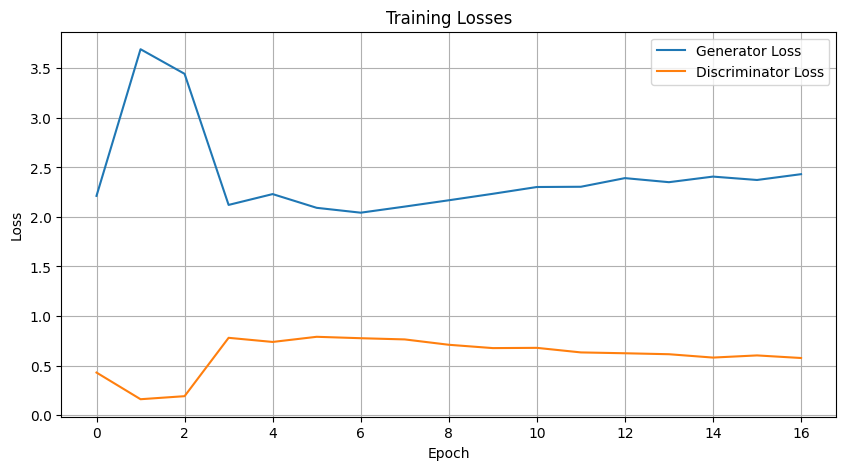

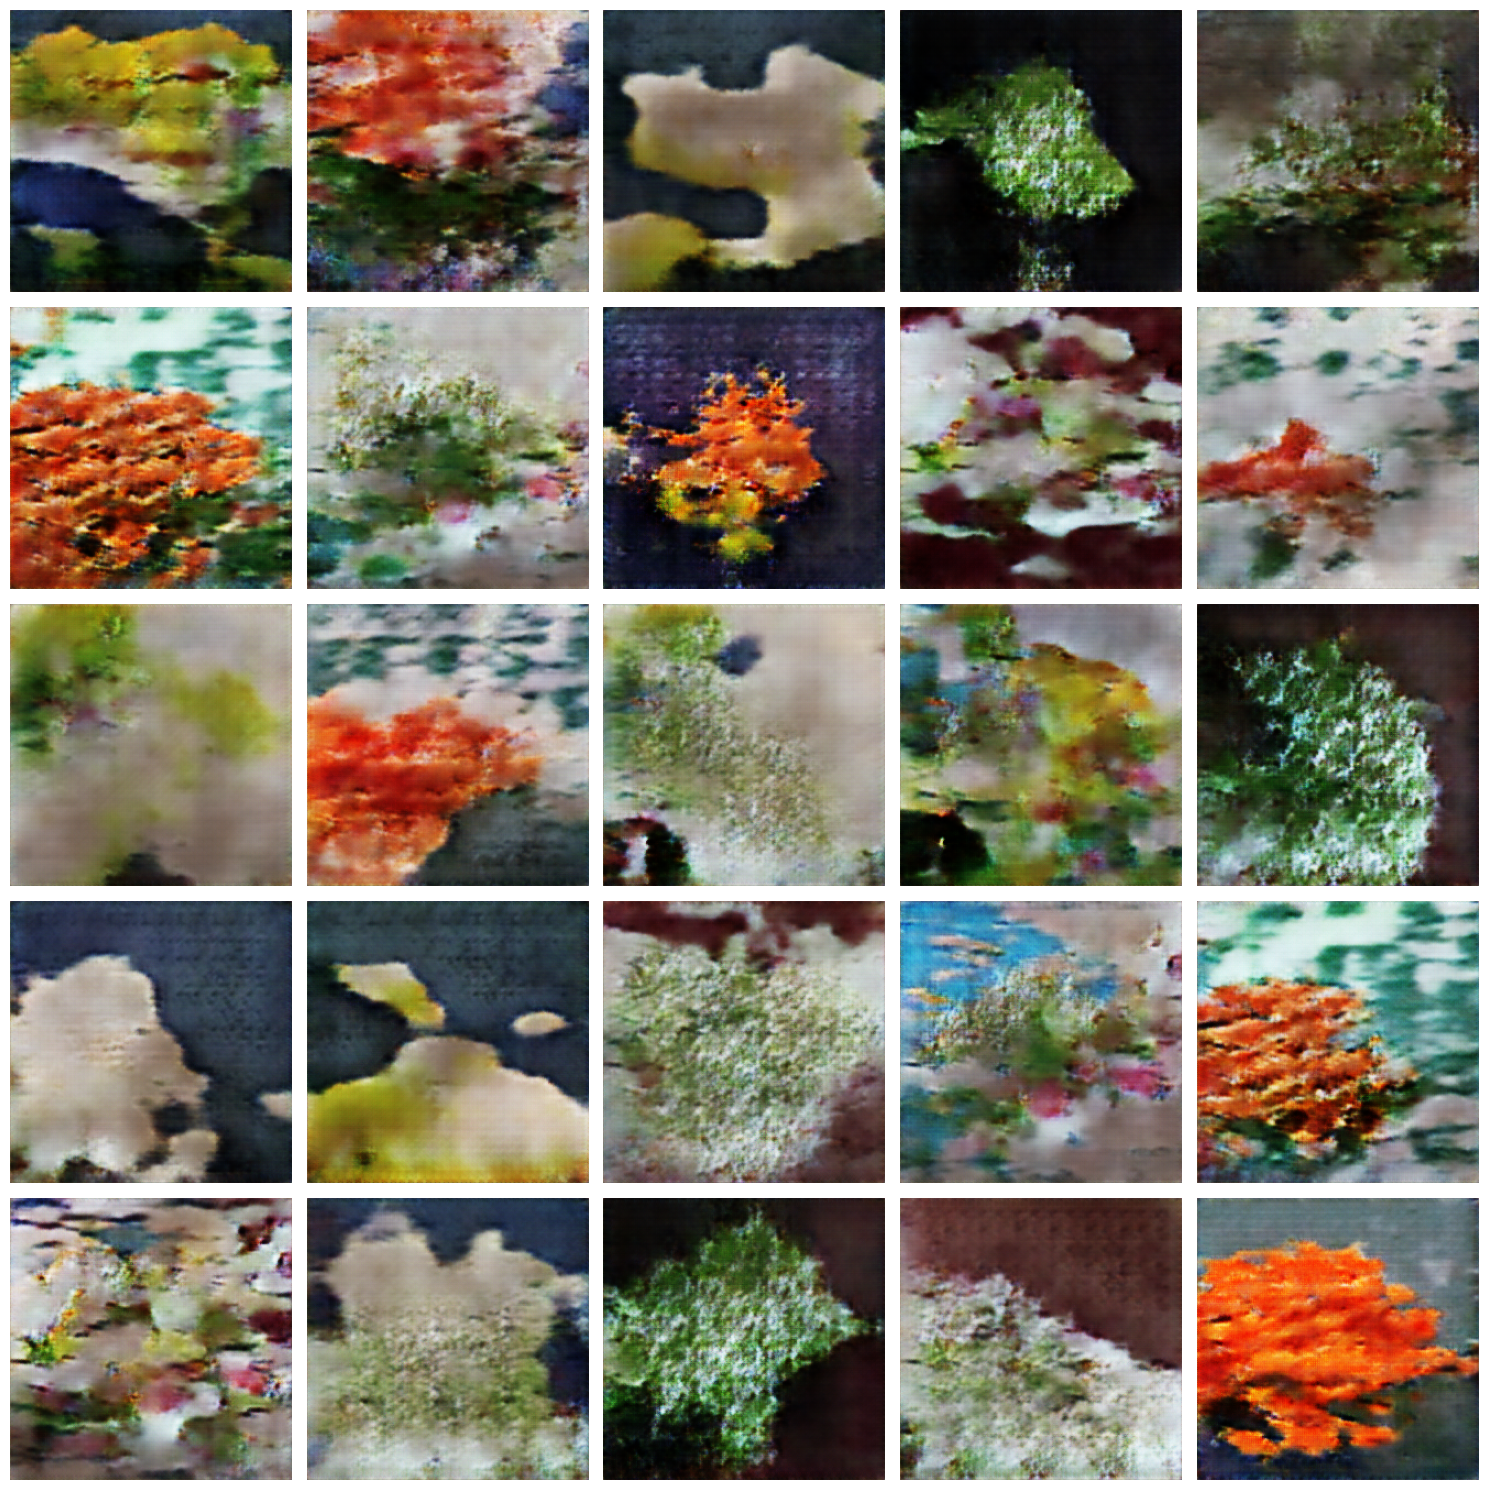

In [64]:
hist = fit(generator, discriminator, dataloader, crit=torch.nn.BCELoss(), num_epochs=30)

# Visualización de la evolución de las pérdidas
df = pd.DataFrame(hist)
plt.figure(figsize=(10, 5))
plt.plot(df['loss_g'], label='Generator Loss')
plt.plot(df['loss_d'], label='Discriminator Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Losses')
plt.legend()
plt.grid(True)
plt.savefig('training_losses.png')
plt.show()

# Generar y visualizar imágenes finales
generator.eval()
with torch.no_grad():
    noise = torch.randn((25, generator.input_size), device=device)
    generated_images = generator(noise).detach().cpu()
    
    # Crear una cuadrícula de 5x5 imágenes
    fig, axs = plt.subplots(5, 5, figsize=(15, 15))
    for i, ax in enumerate(axs.flatten()):
        img = generated_images[i].permute(1, 2, 0).numpy()
        img = (img * 0.5 + 0.5).clip(0, 1)  # Desnormalizar
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.savefig('final_generated_images.png')
    plt.show()

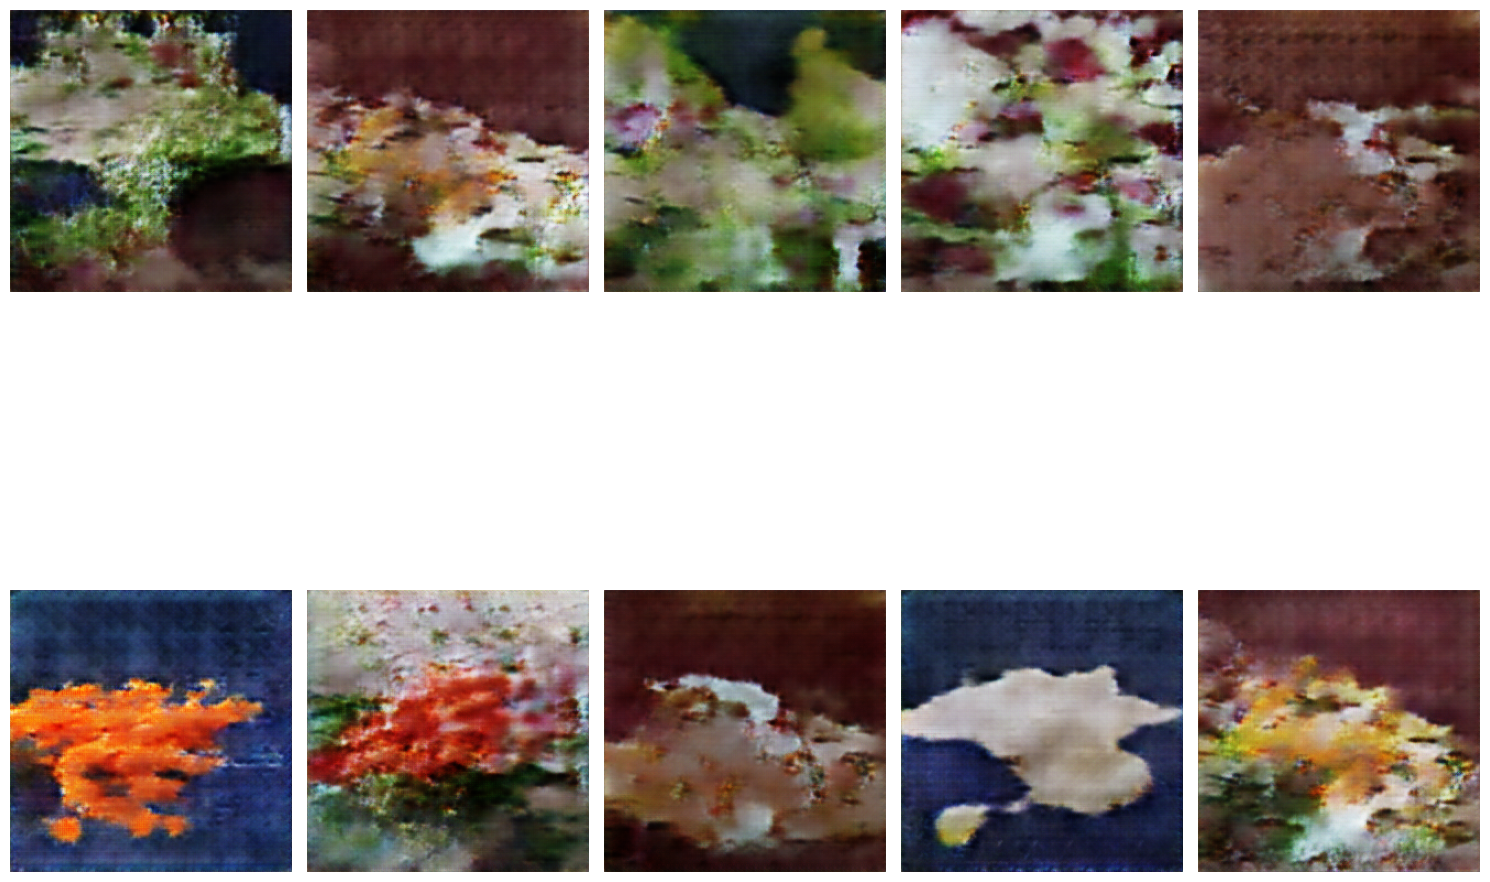

In [74]:
# Generar y visualizar imágenes finales
generator.eval()
with torch.no_grad():
    noise = torch.randn((10, generator.input_size), device=device)
    generated_images = generator(noise).detach().cpu()
    
    # Crear una cuadrícula de 5x5 imágenes
    fig, axs = plt.subplots(2, 5, figsize=(15, 15))
    for i, ax in enumerate(axs.flatten()):
        img = generated_images[i].permute(1, 2, 0).numpy()
        img = (img * 0.5 + 0.5).clip(0, 1)  # Desnormalizar
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.savefig('final_generated_images.png')
    plt.show()